In [3]:
# Import Libraries #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.linear_model import Lasso, LassoCV
import sklearn.metrics 

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

from yellowbrick.regressor import CooksDistance

In [4]:
######################################
##### Primary Research Questions #####
######################################

########################
### Data Preparation ###
########################

# Import Data #
d_price = pd.read_csv(r'D:\SWP\jupyter_workspace\Interview\BGO\Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

In [15]:
# Explore
d_price = pd.DataFrame(d_price)
# np.shape(d_price) # 27021 rows and 286 columns

d_price.head()
# # RegionName = Zipcode
# # Size Rank = 15372 distinct values out of 27021 rows
# # Region Name = Either City or County
# # Region Type = they are all zip
# # Monthly data from 2000.01 ~ 2023.01

RegionID  SizeRank  RegionName RegionType StateName State      City  \
0     91940         0       77449        zip        TX    TX       NaN   
1     91982         1       77494        zip        TX    TX       NaN   
2     93144         2       79936        zip        TX    TX   El Paso   
3     62080         3       11368        zip        NY    NY  New York   
4     62093         4       11385        zip        NY    NY  New York   

                                   Metro        CountyName     2000-01-31  \
0   Houston-The Woodlands-Sugar Land, TX     Harris County  111025.364504   
1   Houston-The Woodlands-Sugar Land, TX  Fort Bend County  217709.460879   
2                            El Paso, TX    El Paso County   93297.846024   
3  New York-Newark-Jersey City, NY-NJ-PA     Queens County   75454.474440   
4  New York-Newark-Jersey City, NY-NJ-PA     Queens County  237548.770794   

   ...     2022-04-30     2022-05-31     2022-06-30     2022-07-31  \
0  ...  267031.277605  271167.441993  274949.991267  277857.050380   
1  ...  460467.367267  467482.802830  473572.893250  477267.065068   
2  ...  180425.647045  182618.423967  184808.073687  186768.821493   
3  ...  336639.762806  336736.022093  337304.550369  337577.574287   
4  ...  743614.071840  750129.456105  757964.299916  763316.251684   

      2022-08-31     2022-09-30     2022-10-31     2022-11-30     2022-12-31  \
0  279379.374979  279571.703469  278978.533186  278001.127045  276453.815200   
1  477984.861877  476524.002739  474871.543073  473490.978602  471547.993017   
2  188315.027071  189360.332747  190107.287314  190872.067470  191400.577159   
3  336818.929821  335031.093053  333107.358734  332435.128586  331124.345954   
4  764586.578334  761489.401151  758818.529559  756929.158762  753410.376751   

      2023-01-31  
0  274671.967839  
1  469380.296915  
2  192365.842160  
3  331082.536088  
4  750163.629656  

[5 rows x 286 columns]

In [16]:
# drop columns
d_price2 = d_price.copy()

# interpolate missing values (no more then 12 consecutive NaN)
d_price2.loc[:,'2000-01-31':'2023-01-31'] = d_price2.loc[:,'2000-01-31':'2023-01-31'].interpolate(method="linear", axis = 1, limit_direction = 'both', limit = 12)

d_price2 = d_price2.drop(columns=['RegionID', 'RegionType', 'StateName', 'Metro', 'CountyName', 'SizeRank'])
# print(d_price2.head())
# print(list(d_price2.columns))

In [5]:
# Transpose
d_price3 = pd.melt(d_price2, 
        id_vars=['RegionName', 'State', 'City'], 
        value_vars=list(d_price2.columns),
        var_name='date', 
        value_name='ZHVI'
       ).sort_values(by=['RegionName','date'], ascending=True)

# print(d_price3.head())
# print(d_price3.isna().sum())

In [6]:
# tag missing ZHVI
d_price3['null_tag'] = np.where(d_price3['ZHVI'].isna(), 1, 0)

# convert type to date & keep the year
d_price3["date"] = pd.to_datetime(d_price3["date"])
d_price3["year"] = d_price3["date"].dt.year
d_price3["month"] = d_price3["date"].dt.month

# print(d_price3.head())

In [7]:
# keep january only
d_price4 = d_price3[d_price3['month'] == 1]
# print(d_price4.head())

# remove columns
d_price4 = d_price4.drop(columns=['date', 'month'])
# print(d_price4.head())

# create id for join
d_price4["id"] = d_price4['year'].astype(str) +"_"+ d_price4["RegionName"].astype(str)

# print(d_price4.head())
# print(d_price4.dtypes)

In [35]:
# Import census
d_census = pd.read_csv(r'D:\SWP\jupyter_workspace\Interview\BGO\BGO_challenge_census_data.csv')
d_census = pd.DataFrame(d_census.sort_index(axis=1)).sort_values(by=['zcta','year'], ascending=True)
# print(d_census.head())
# print(d_census.isna().sum())
# print(len(d_census.index))

# remove columns with only null values
d_census1 = d_census.drop(columns=['B07413PR_002E', 'B07413PR_003E', 'B08537_002E', 'B08537_003E'])
# print(d_census1.isna().sum())

# null tag
d_census1['B07009_002E_null'] = np.where(d_census1['B07009_002E'].isna(), 1, 0)
d_census1['B07009_003E_null'] = np.where(d_census1['B07009_003E'].isna(), 1, 0)
d_census1['B07009_004E_null'] = np.where(d_census1['B07009_003E'].isna(), 1, 0)
d_census1['B07009_005E_null'] = np.where(d_census1['B07009_003E'].isna(), 1, 0)
d_census1['B07009_006E_null'] = np.where(d_census1['B07009_003E'].isna(), 1, 0)

d_census1['B08006_017E_null'] = np.where(d_census1['B08006_017E'].isna(), 1, 0)
d_census1['B08101_049E_null'] = np.where(d_census1['B08101_049E'].isna(), 1, 0)

d_census1['B19019_001E_null'] = np.where(d_census1['B19019_001E'].isna(), 1, 0)

d_census1['B25031_001E_null'] = np.where(d_census1['B25031_001E'].isna(), 1, 0)

In [9]:
# check missing values
d_census1[['year','zcta']][d_census1['B07009_002E'].isna()]

# create id for join
d_census1['id'] = d_census1['year'].astype(str) +"_"+ d_census["zcta"].astype(str)

In [10]:
# join price & census
d_price5 = d_price4.merge(d_census1, on='id', how='inner')
# print(list(d_price5.columns))

# drop columns & sort values
d_price5 = d_price5.drop(columns=['id','year_y','zcta'])
d_price5 = d_price5.sort_values(by=['RegionName','year_x'], ascending=True)

# # print(list(d_price5.columns))
# print(d_price5.head())

# # check for columns with null values
# print(d_price5.isna().any())

In [11]:
###################################################
### Prediction & Feature Importance Using LASSO ###
###################################################

# clean up features
d_price_f = d_price5.drop(columns=['null_tag',
                                   'B07009_002E_null', 'B07009_003E_null', 'B07009_004E_null', 'B07009_005E_null', 'B07009_006E_null',
                                   'B08006_017E_null', 'B08101_049E_null', 'B19019_001E_null','B25031_001E_null',
                                   'RegionName','year_x', 'State', 'City']).dropna() # drop null values

# define target & predictor
X = d_price_f.drop('ZHVI', axis=1)
y = d_price_f['ZHVI']

# split train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 12345)

# standardize features
sc=StandardScaler()
scaler = sc.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

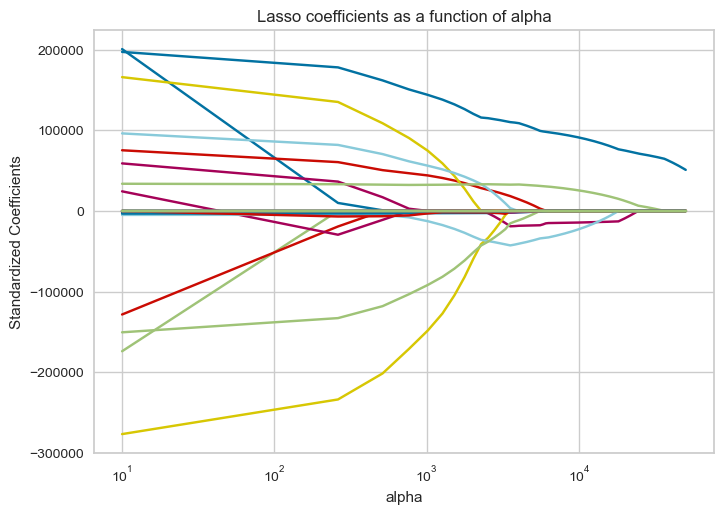

In [12]:
# plot alpha vs coefficients
alphas = np.linspace(10,50000,200)
lasso = Lasso(max_iter = 100000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

In [13]:
# Find optimal alpha using LassoCV
model = LassoCV(cv=5, 
                max_iter = 100000,
                random_state=0,
                verbose = 0)

model.fit(X_train, y_train)

lasso_alpha = model.alpha_
print(lasso_alpha)

100.89379910367018


In [14]:
# Fit model using the optimal alpha
model = Lasso(alpha = lasso_alpha,
              max_iter = 100000)
model.fit(X_train, y_train)

# prediction on the test set
yhat = model.predict(X_test)

In [15]:
# calculate RMSE 
lasso_mse = sklearn.metrics.mean_squared_error(y_test, yhat)    
rmse = math.sqrt(lasso_mse)  
print(rmse)

# calculate MAE
lasso_mae = sklearn.metrics.mean_absolute_error(y_test, yhat)
print(lasso_mae)

168366.46621679707
95486.60772534173


    feature_name    coefficient
12   B07009_006E  189143.441537
10   B07009_004E  153746.076661
11   B07009_005E   89972.590488
8    B07009_002E   68468.759339
9    B07009_003E   49771.583066
13   B08006_017E   33687.202430
0   B01001A_001E   17154.172600
25   B25087_002E      -0.000000
14   B08101_049E       0.000000
24   B25087_001E      -0.000000
23   B25056_001E      -0.000000
22   B25042_009E      -0.000000
21   B25038_009E      -0.000000
1   B01001A_017E      -0.000000
7    B01003_001E     -81.361205
15   B19019_001E    -503.216039
4    B01002_001E    -816.702747
5    B01002_002E   -1074.394706
6    B01002_003E   -2155.449838
20   B25036_002E   -2233.409692
18   B25031_001E   -3186.144383
17   B25027_010E   -5381.768590
3    B01001_026E  -33595.947434
2    B01001_002E  -44805.008928
19   B25032_013E -142764.351177
16   B25013_002E -259798.445523


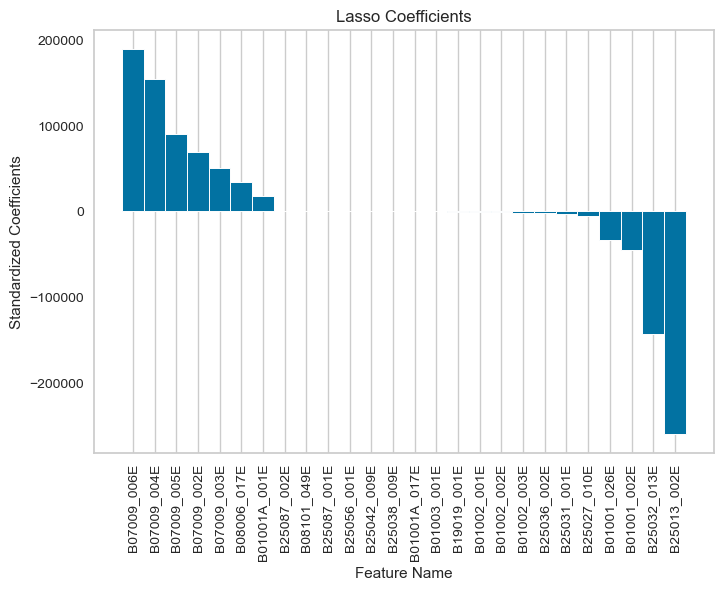

In [16]:
# feature importance
lasso_coefs = pd.DataFrame({'feature_name' : list(X.columns),
                            'coefficient' : list(model.coef_)}).sort_values(by='coefficient', ascending=False) 

print(lasso_coefs)

# plot
fig, ax = plt.subplots()

ax.bar(lasso_coefs.feature_name, 
       lasso_coefs.coefficient, 
       width=1, edgecolor="white", linewidth=0.7)

plt.xticks(rotation=90)
plt.xlabel('Feature Name')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso Coefficients');

plt.grid(axis = 'y')

plt.show()

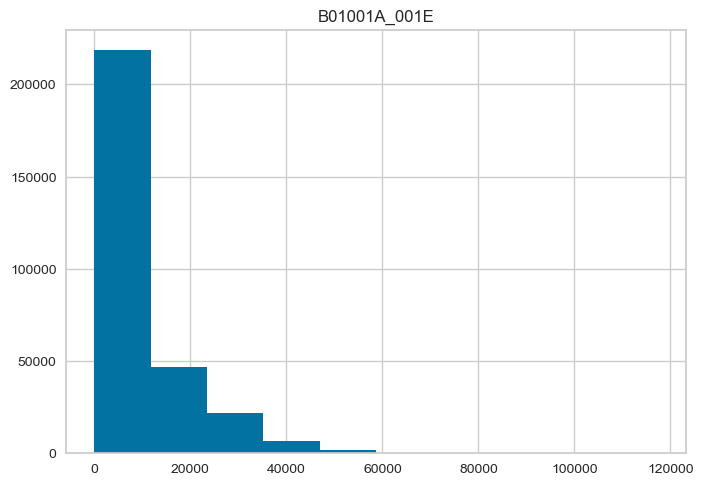

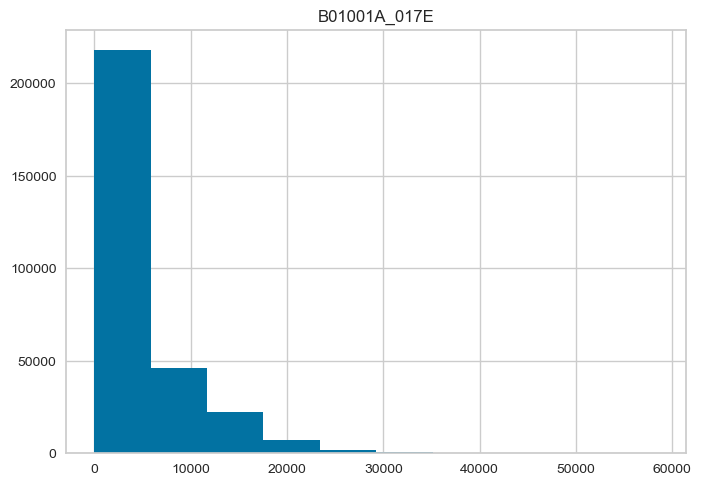

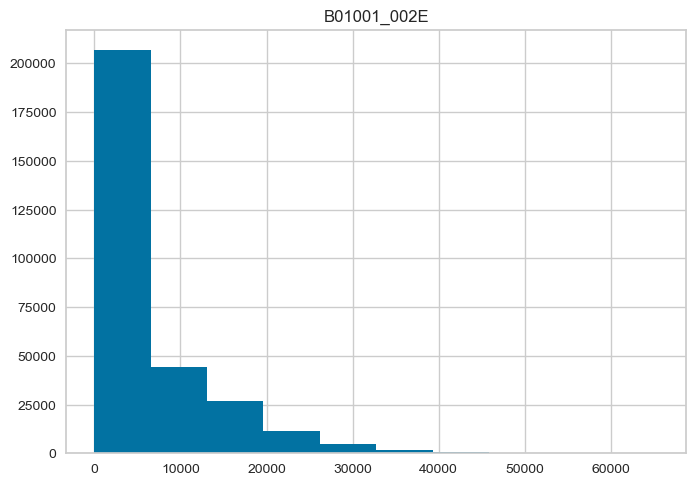

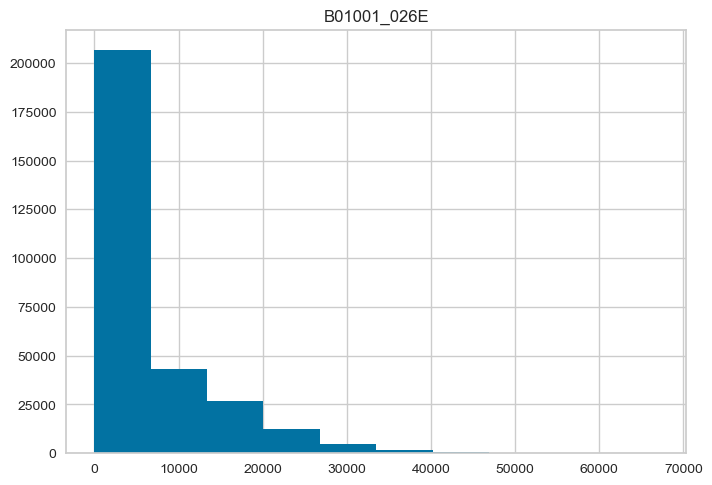

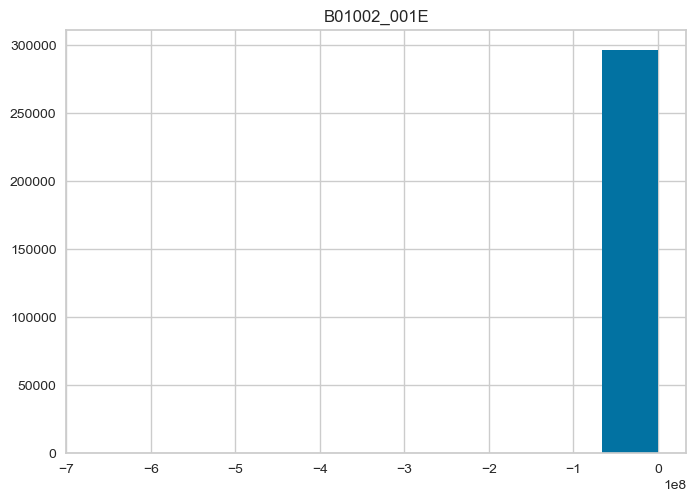

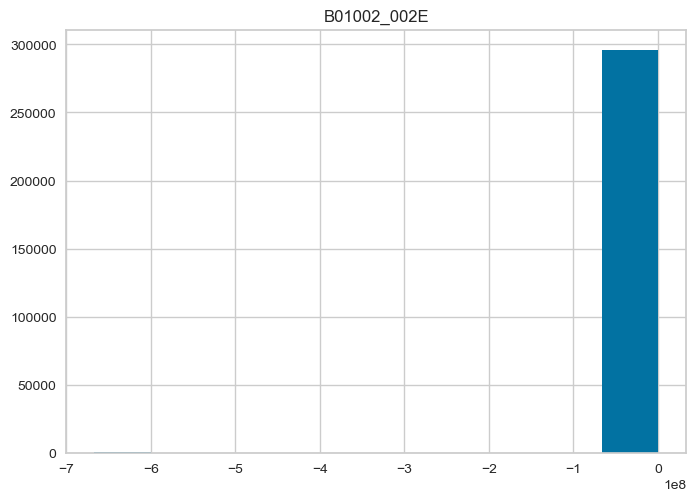

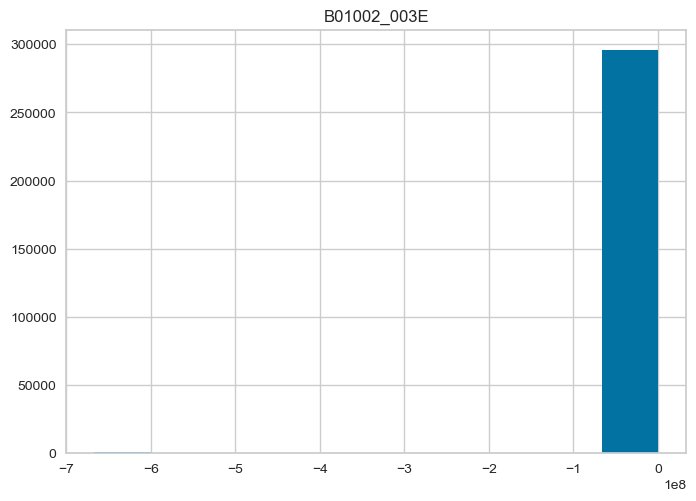

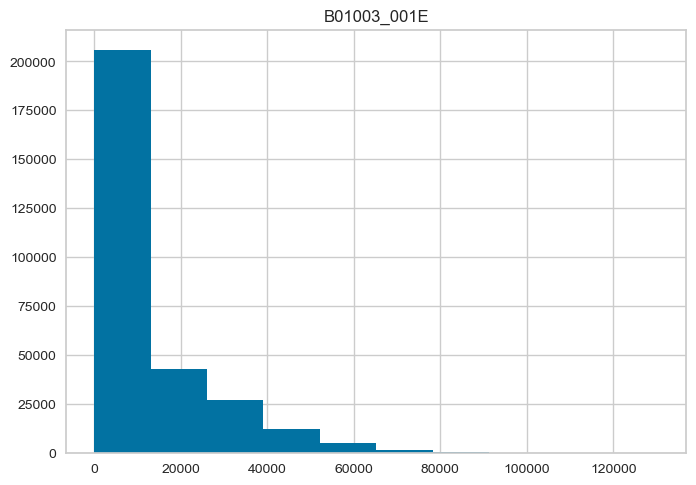

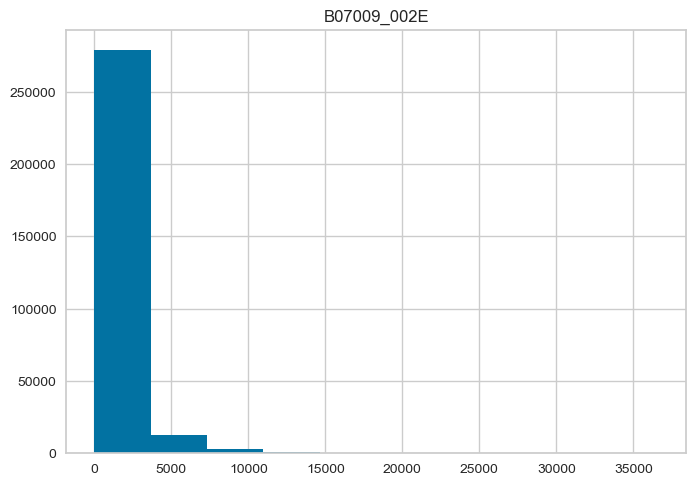

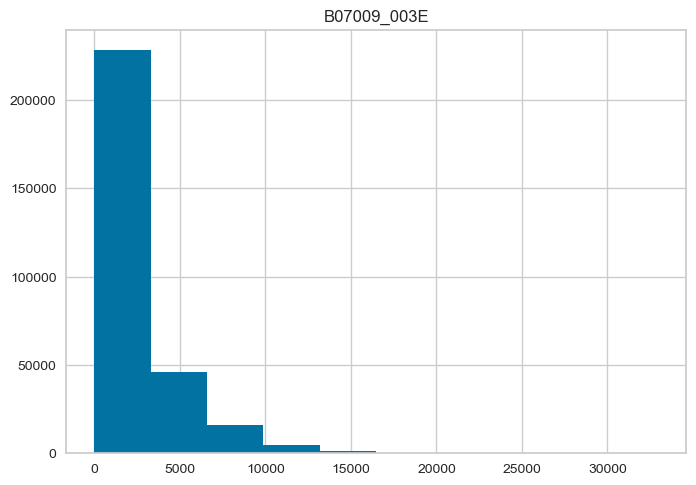

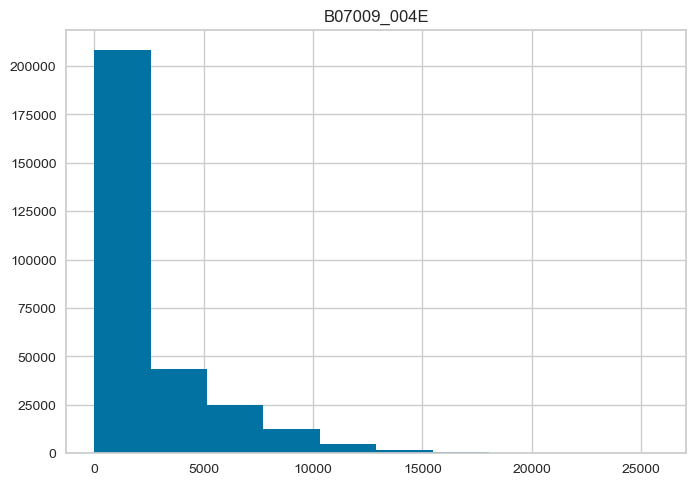

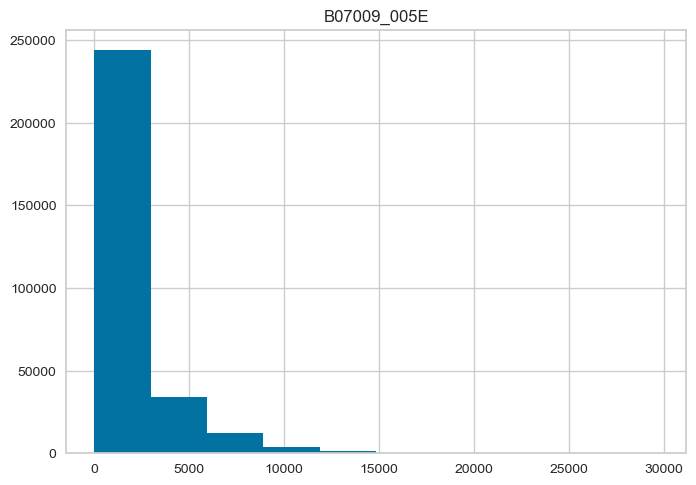

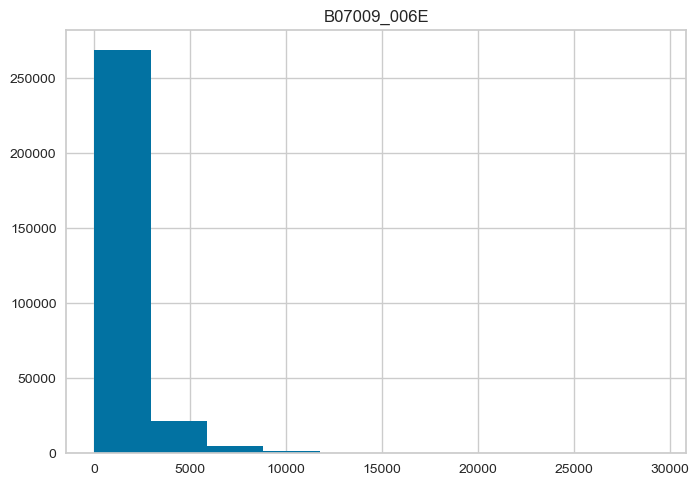

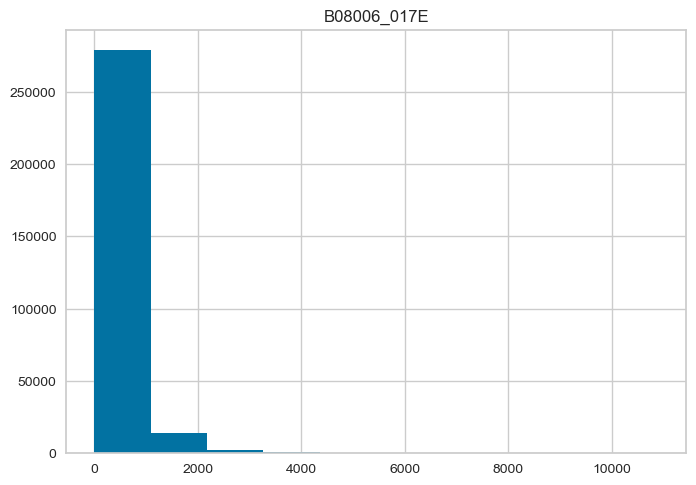

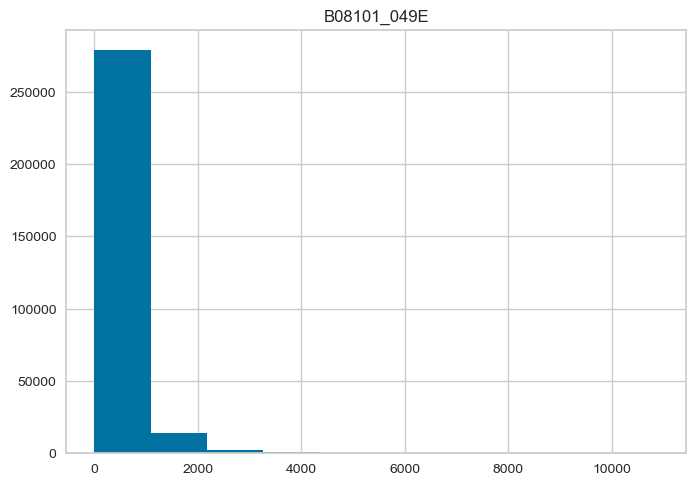

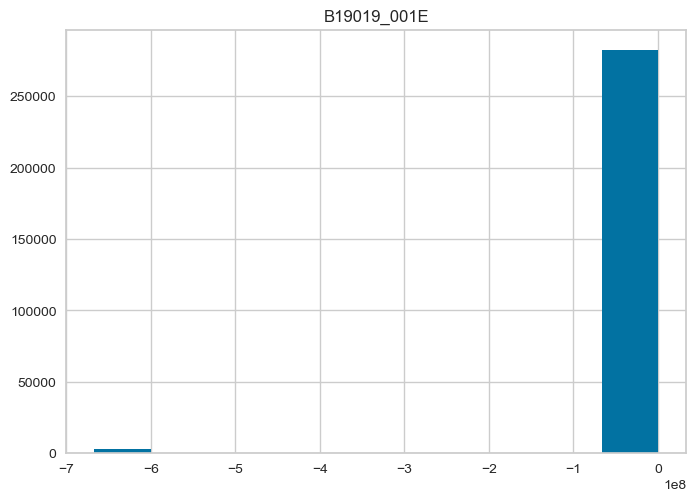

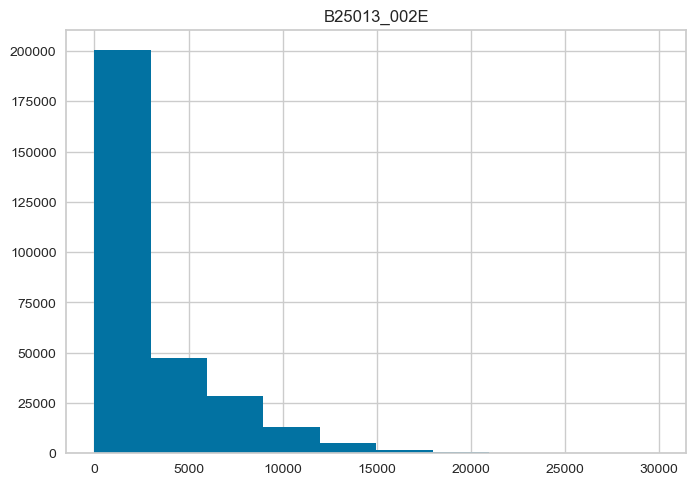

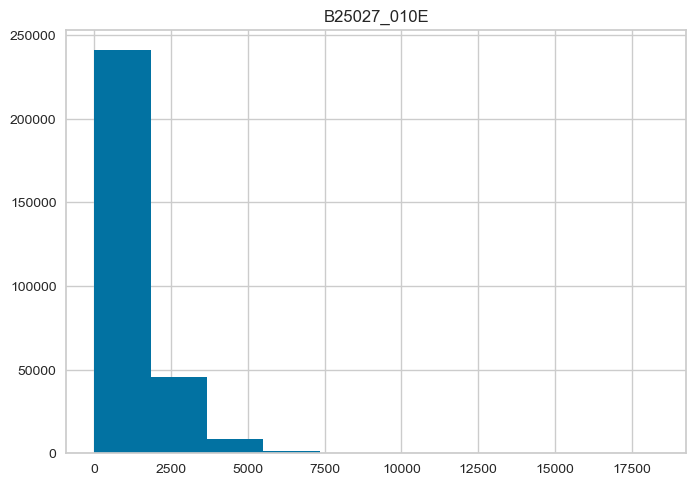

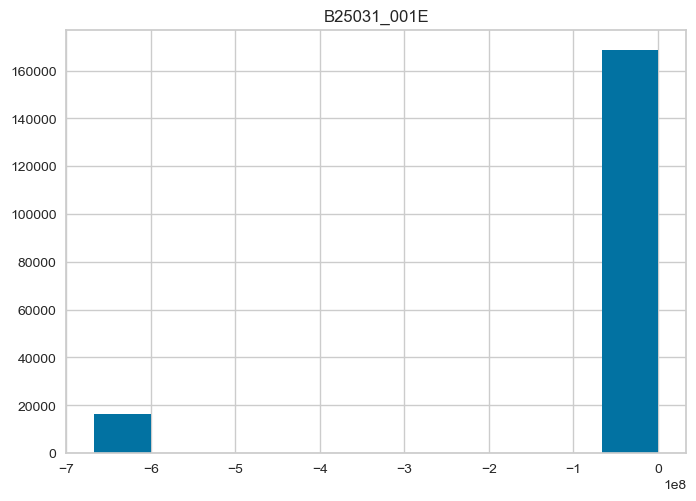

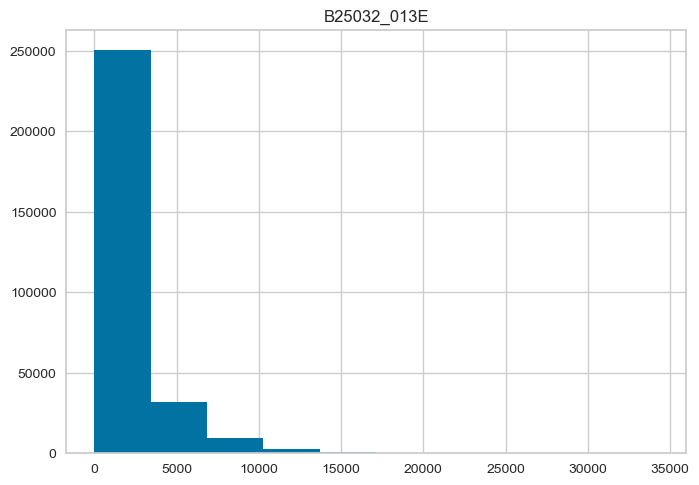

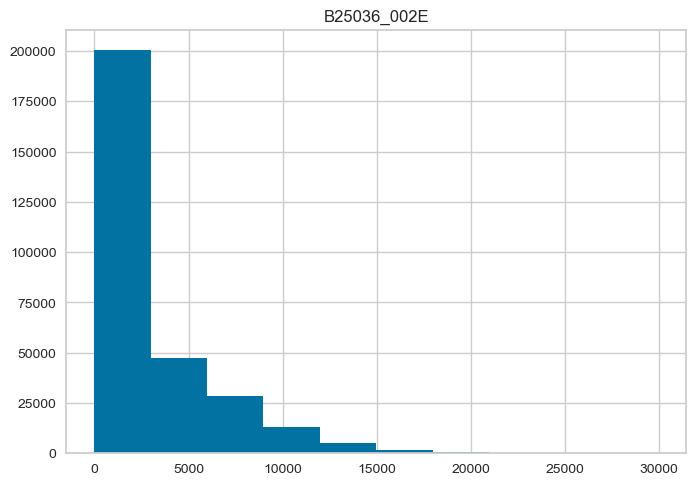

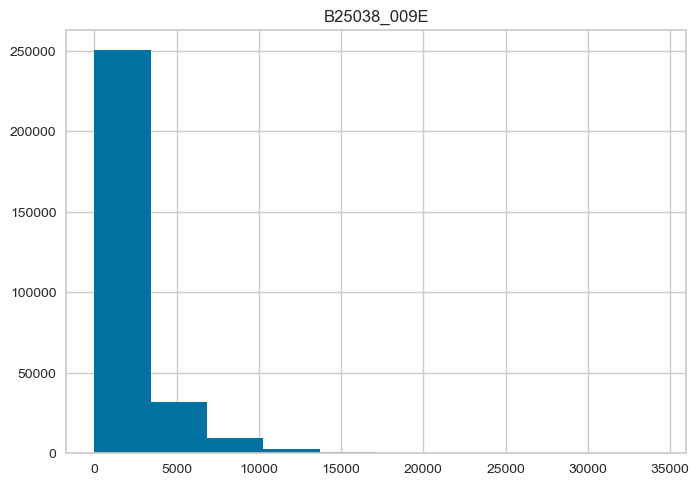

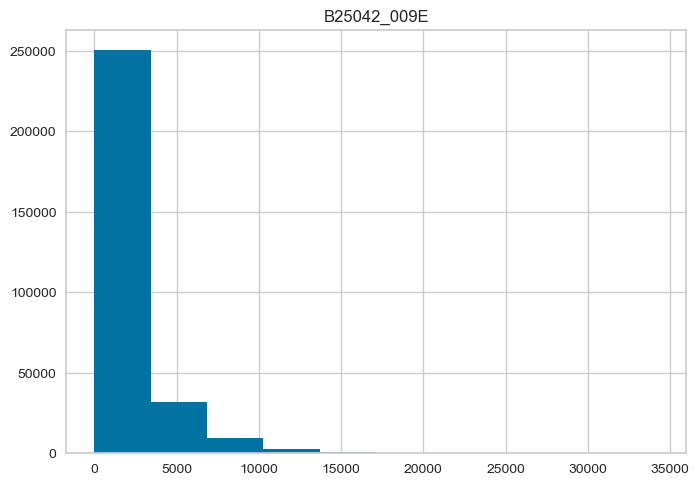

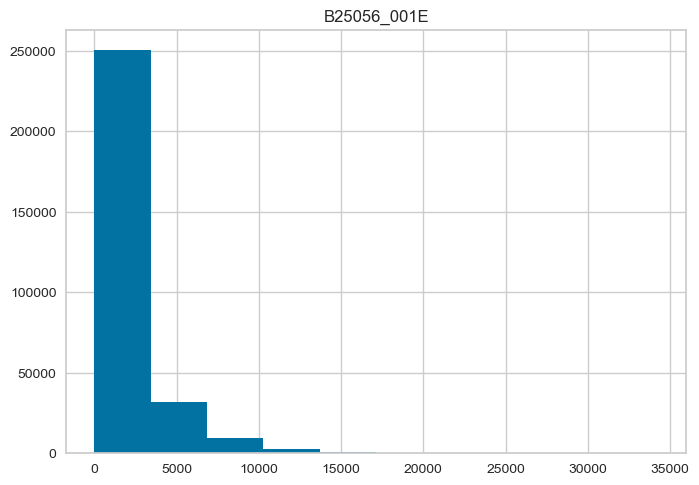

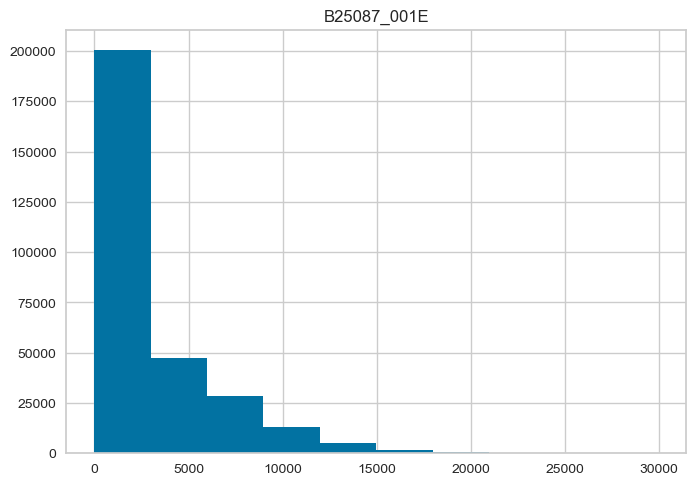

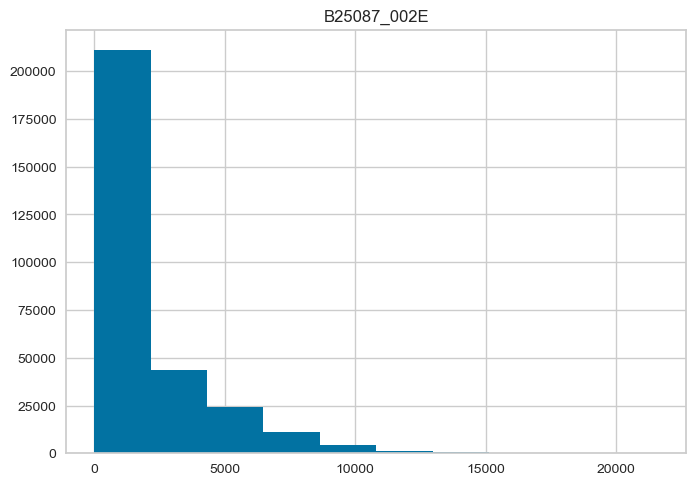

In [17]:
###########################
### Feature Engineering ###
###########################

# Interpolate missing values
# Transformation skewed features

# feature columns
feature_cols = list(d_census1.loc[:,'B01001A_001E':'B25087_002E'].columns)
feature_vals = d_price5[feature_cols]

# Check distirbution of feature values. If skewed, try log/square root transformation.
for j in range(len(feature_vals.columns)):
    plt.figure()
    plt.hist(feature_vals.iloc[:,j])
    plt.title(list(feature_vals.columns)[j])    
    plt.show()

In [18]:
### Step 1 - Negative/Null median age, household income, median gross rent ###

col_age = ['B01002_001E','B01002_002E','B01002_003E', 'B19019_001E', 'B25031_001E']
d_price_fe1 = d_price5.copy()

print(d_price5[col_age].isna().sum())
print(d_price5[col_age][d_price_fe1[col_age] < 0].count())

# Replace negative ages with null
d_price_fe1['B01002_001E'][d_price_fe1['B01002_001E'] < 0] = np.NaN
d_price_fe1['B01002_002E'][d_price_fe1['B01002_002E'] < 0] = np.NaN
d_price_fe1['B01002_003E'][d_price_fe1['B01002_003E'] < 0] = np.NaN
d_price_fe1['B19019_001E'][d_price_fe1['B19019_001E'] < 0] = np.NaN
d_price_fe1['B25031_001E'][d_price_fe1['B25031_001E'] < 0] = np.NaN

print(d_price_fe1[col_age].isna().sum())
print(d_price_fe1[col_age][d_price_fe1[col_age] < 0].count())

B01002_001E         0
B01002_002E         0
B01002_003E         0
B19019_001E     11276
B25031_001E    111312
dtype: int64
B01002_001E      240
B01002_002E      562
B01002_003E      580
B19019_001E     2827
B25031_001E    16508
dtype: int64
B01002_001E       240
B01002_002E       562
B01002_003E       580
B19019_001E     14103
B25031_001E    127820
dtype: int64
B01002_001E    0
B01002_002E    0
B01002_003E    0
B19019_001E    0
B25031_001E    0
dtype: int64


C:\Users\gubug\AppData\Local\Temp\ipykernel_13232\996807419.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_price_fe1['B01002_001E'][d_price_fe1['B01002_001E'] < 0] = np.NaN
C:\Users\gubug\AppData\Local\Temp\ipykernel_13232\996807419.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_price_fe1['B01002_002E'][d_price_fe1['B01002_002E'] < 0] = np.NaN
C:\Users\gubug\AppData\Local\Temp\ipykernel_13232\996807419.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [19]:
# Calculate median age for each year (year_x)
med_age_all = pd.DataFrame(d_price_fe1.groupby(["year_x"], dropna = True)["B01002_001E"].median())
med_age_male = pd.DataFrame(d_price_fe1.groupby(["year_x"], dropna = True)["B01002_002E"].median())
med_age_female = pd.DataFrame(d_price_fe1.groupby(["year_x"], dropna = True)["B01002_003E"].median())

med_hhincome = pd.DataFrame(d_price_fe1.groupby(["year_x"], dropna = True)["B19019_001E"].median())
med_grent = pd.DataFrame(d_price_fe1.groupby(["year_x"], dropna = True)["B25031_001E"].median())

print(med_age_all)
print(med_age_male)
print(med_age_female)
print(med_hhincome)
print(med_grent) # B25031_001E about 43% of the observations are null (2011 - 2014)

        B01002_001E
year_x             
2011           40.4
2012           40.7
2013           40.9
2014           41.2
2015           41.4
2016           41.6
2017           41.7
2018           41.8
2019           41.8
2020           41.8
2021           41.7
        B01002_002E
year_x             
2011           39.3
2012           39.6
2013           39.8
2014           40.0
2015           40.2
2016           40.4
2017           40.4
2018           40.4
2019           40.5
2020           40.5
2021           40.7
        B01002_003E
year_x             
2011          41.50
2012          41.70
2013          42.00
2014          42.30
2015          42.50
2016          42.70
2017          42.80
2018          43.00
2019          43.00
2020          43.10
2021          42.75
        B19019_001E
year_x             
2011        48160.0
2012        48593.5
2013        48817.0
2014        49408.0
2015        51929.0
2016        51184.0
2017        52863.0
2018        54965.0
2019        57060.5


In [20]:
# interpolate 2011- 2014 values 
med_grent['B25031_001E'] = med_grent['B25031_001E'].interpolate(method="linear",
                                                                limit_direction = 'backward') # ‘forward’, ‘backward’, ‘both’
print(med_grent)

        B25031_001E
year_x             
2011          756.0
2012          756.0
2013          756.0
2014          756.0
2015          756.0
2016          767.0
2017          788.0
2018          813.0
2019          828.0
2020          847.0
2021          890.0


In [21]:
# Impute the calculated median age
for i in range(len(d_price_fe1.index)):
    if np.isnan(d_price_fe1['B01002_001E'][i]) == True:
        d_price_fe1['B01002_001E'][i] = med_age_all.loc[d_price_fe1['year_x'][i]]
    else:
        continue
        
for i in range(len(d_price_fe1.index)):
    if np.isnan(d_price_fe1['B01002_002E'][i]) == True:
        d_price_fe1['B01002_002E'][i] = med_age_male.loc[d_price_fe1['year_x'][i]]
    else:
        continue
        
for i in range(len(d_price_fe1.index)):
    if np.isnan(d_price_fe1['B01002_003E'][i]) == True:
        d_price_fe1['B01002_003E'][i] = med_age_female.loc[d_price_fe1['year_x'][i]]
    else:
        continue
        
for i in range(len(d_price_fe1.index)):
    if np.isnan(d_price_fe1['B19019_001E'][i]) == True:
        d_price_fe1['B19019_001E'][i] = med_hhincome.loc[d_price_fe1['year_x'][i]]
    else:
        continue
        
for i in range(len(d_price_fe1.index)):
    if np.isnan(d_price_fe1['B25031_001E'][i]) == True:
        d_price_fe1['B25031_001E'][i] = med_grent.loc[d_price_fe1['year_x'][i]]
    else:
        continue
        
print(d_price_fe1[col_age].isna().sum())
print(d_price_fe1[col_age][d_price_fe1[col_age] < 0].count())

C:\Users\gubug\AppData\Local\Temp\ipykernel_13232\2512387460.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_price_fe1['B01002_001E'][i] = med_age_all.loc[d_price_fe1['year_x'][i]]
C:\Users\gubug\AppData\Local\Temp\ipykernel_13232\2512387460.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_price_fe1['B01002_002E'][i] = med_age_male.loc[d_price_fe1['year_x'][i]]
C:\Users\gubug\AppData\Local\Temp\ipykernel_13232\2512387460.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

B01002_001E    0
B01002_002E    0
B01002_003E    0
B19019_001E    0
B25031_001E    0
dtype: int64
B01002_001E    0
B01002_002E    0
B01002_003E    0
B19019_001E    0
B25031_001E    0
dtype: int64


In [22]:
### Step2. Transformation ###

d_price_fe2 = d_price_fe1.drop(columns=['null_tag',
                                        'B07009_002E_null', 'B07009_003E_null', 'B07009_004E_null', 'B07009_005E_null', 'B07009_006E_null',
                                        'B08006_017E_null', 'B08101_049E_null', 'B19019_001E_null','B25031_001E_null',
                                        'RegionName','year_x', 'State', 'City']).dropna() # drop null values
# print(list(d_price_fe2.columns))



# log(1+x) transformation
X_log = np.log(d_price_fe2.drop('ZHVI', axis=1)+1)
y = d_price_fe2['ZHVI']

# split train & test
X_train, X_test, y_train, y_test = train_test_split(X_log, y, test_size=0.3, random_state= 12345)

# standardize features
sc=StandardScaler()
scaler = sc.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
# Find optimal alpha using LassoCV
model2 = LassoCV(cv=5, 
                max_iter = 100000,
                random_state=0,
                verbose = 0)

model2.fit(X_train, y_train)

lasso_alpha2 = model2.alpha_
print(lasso_alpha2)

117.3195491669888


In [24]:
# Fit model using the optimal alpha
model2 = Lasso(alpha = lasso_alpha2,
              max_iter = 100000)

model2.fit(X_train, y_train)

# prediction on the test set
yhat2 = model2.predict(X_test)

In [25]:
# calculate RMSE 
lasso_mse2 = sklearn.metrics.mean_squared_error(y_test, yhat2)    
rmse2 = math.sqrt(lasso_mse2)  
print(rmse2)

# calculate MAE
lasso_mae2 = sklearn.metrics.mean_absolute_error(y_test, yhat2)
print(lasso_mae2)

# Previous RMSE and MAE 
# 168366.46621679707
# 95486.60772534173

118407.85580058767
64718.84798525079


    feature_name   coefficient
2    B01001_002E  1.819679e+05
3    B01001_026E  1.589248e+05
15   B19019_001E  6.866615e+04
18   B25031_001E  4.900436e+04
7    B01003_001E  4.652287e+04
4    B01002_001E  2.691654e+04
5    B01002_002E  1.695462e+04
19   B25032_013E  1.638063e+04
21   B25038_009E  1.560867e+04
13   B08006_017E  1.413598e+04
6    B01002_003E  1.409183e+04
17   B25027_010E  8.367154e+03
8    B07009_002E  4.819873e+02
14   B08101_049E  3.229652e-09
22   B25042_009E  1.105718e-09
23   B25056_001E  0.000000e+00
0   B01001A_001E -0.000000e+00
25   B25087_002E -0.000000e+00
11   B07009_005E -1.535785e+03
12   B07009_006E -2.822325e+03
24   B25087_001E -1.357569e+04
1   B01001A_017E -1.417155e+04
20   B25036_002E -1.794610e+04
10   B07009_004E -9.823989e+04
16   B25013_002E -1.060075e+05
9    B07009_003E -1.608533e+05


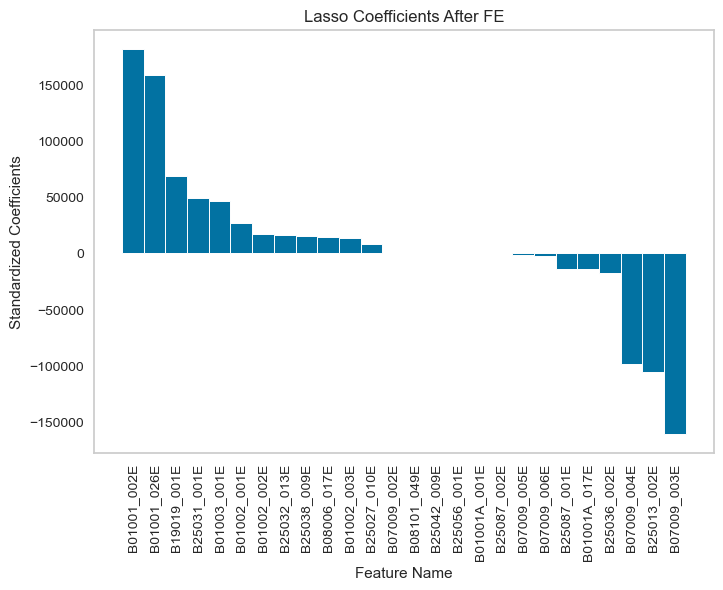

In [26]:
# feature importance
lasso_coefs2 = pd.DataFrame({'feature_name' : list(X_log.columns),
                             'coefficient' : list(model2.coef_)}).sort_values(by='coefficient', ascending=False) 

print(lasso_coefs2)


# plot
fig, ax = plt.subplots()

ax.bar(lasso_coefs2.feature_name, 
       lasso_coefs2.coefficient, 
       width=1, edgecolor="white", linewidth=0.7)

plt.xticks(rotation=90)
plt.xlabel('Feature Name')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso Coefficients After FE');

plt.grid(axis = 'both')

plt.show()

In [17]:
########################################
##### Secondary Research Questions #####
########################################

#####################
### 1. Clustering ###
#####################

d_clus = d_price2.copy()

# impute missing city
d_clus["City"].fillna('No_City', inplace=True)
# print(d_clus.isna().sum())

# define period
d_clus2 = d_clus.loc[:,'2015-02-28':'2023-01-31'] # last 10 years
# print(d_clus2.isna().sum()/len(d_clus2.index)) # about 11% of data has null
# # Length: 280, dtype: int64
# # 2015-01-31    0.173828
# # 2015-02-28    0.120055
# # 2015-03-31    0.119981
# # 2015-04-30    0.119981
# # 2015-05-31    0.119981

In [24]:
# d_clus = d_clus.dropna()
d_clus2 = d_clus2.dropna()
d_clus3 = d_clus2.copy()
d_clus = d_clus.iloc[list(d_clus2.index),:]

colnames = d_clus2.columns.tolist()
# print(colnames)

for i in range(1, len(colnames)):
    d_clus3[colnames[i-1] + '_' + colnames[i]] = (d_clus3[colnames[i]] - d_clus3[colnames[i-1]]) / d_clus3[colnames[i-1]]

d_clus3 = d_clus3.loc[:,"2015-02-28_2015-03-31":]
# print(d_clus3.columns)

In [9]:
# Transform & Standardize

# log(1+x) transformation
d_clus3_log = np.log(d_clus3+1)

# standardize features
sc=StandardScaler()
scaler = sc.fit(d_clus3_log)
d_clus3_logstd = scaler.transform(d_clus3_log)

In [30]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 0,
}

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []
sse = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(d_clus3_logstd)
    score = silhouette_score(d_clus3_logstd, kmeans.labels_)
    silhouette_coefficients.append(score)
    sse.append(kmeans.inertia_)

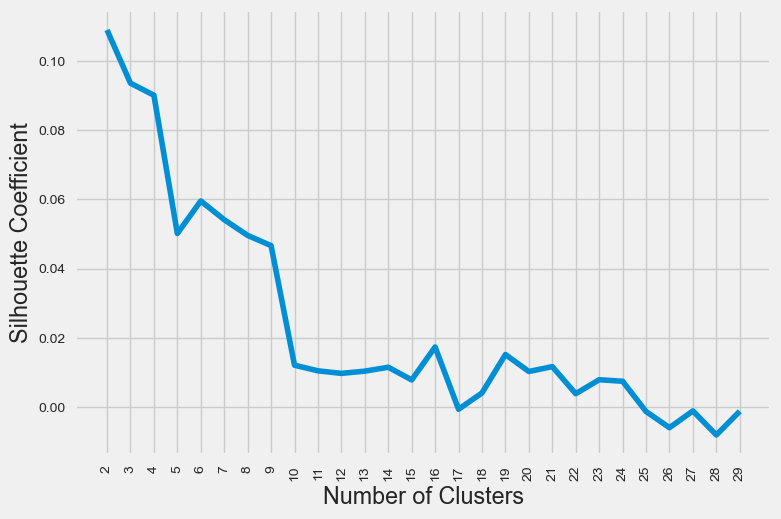

In [31]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 30), silhouette_coefficients)
plt.xticks(range(2, 30))
plt.xticks(rotation=90)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

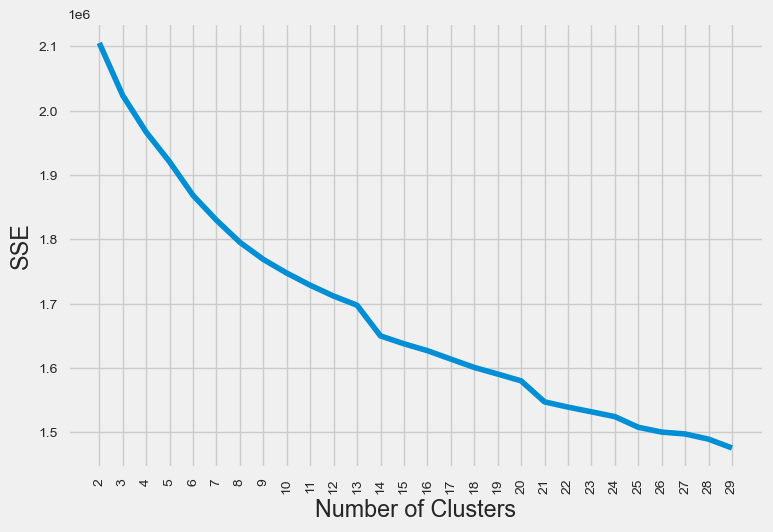

In [32]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 30), sse)
plt.xticks(range(2, 30))
plt.xticks(rotation=90)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [27]:
# 6 clusters
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 0,
}

kmeans_6 = KMeans(n_clusters = 6, **kmeans_kwargs)
clus_results = kmeans_6.fit(d_clus3_logstd)

In [57]:
# 3 clusters
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 0,
}

kmeans_3 = KMeans(n_clusters = 3, **kmeans_kwargs)
clus_results = kmeans_3.fit(d_clus3_logstd)

In [60]:
# add cluster info
clus_label2 = clus_results.labels_
d_clus['cluster3'] = clus_label2

In [45]:
# summarise 2021 census info by cluster6
d_census_2021 = d_census1.loc[:,'B01001A_001E':'zcta'][d_census1['year'] == 2021]
d_clus_info = d_clus.merge(d_census_2021, how='left', left_on = 'RegionName', right_on = 'zcta')
feature_cols = list(d_census1.loc[:,'B01001A_001E':'B25087_002E'].columns)
clus_info_save = np.transpose(d_clus_info.groupby(["cluster6"], dropna = True)[feature_cols].mean())

# export to csv
# clus_info_save.to_csv('D:\SWP\jupyter_workspace\Interview\BGO\clus_info.csv', sep=',')

In [62]:
# summarise 2021 census info by cluster3
d_census_2021 = d_census1.loc[:,'B01001A_001E':'zcta'][d_census1['year'] == 2021]
d_clus_info = d_clus.merge(d_census_2021, how='left', left_on = 'RegionName', right_on = 'zcta')
feature_cols = list(d_census1.loc[:,'B01001A_001E':'B25087_002E'].columns)
clus_info_save3 = np.transpose(d_clus_info.groupby(["cluster3"], dropna = True)[feature_cols].mean())

# clus_info_save3.to_csv('D:\SWP\jupyter_workspace\Interview\BGO\clus3_info.csv', sep=',')

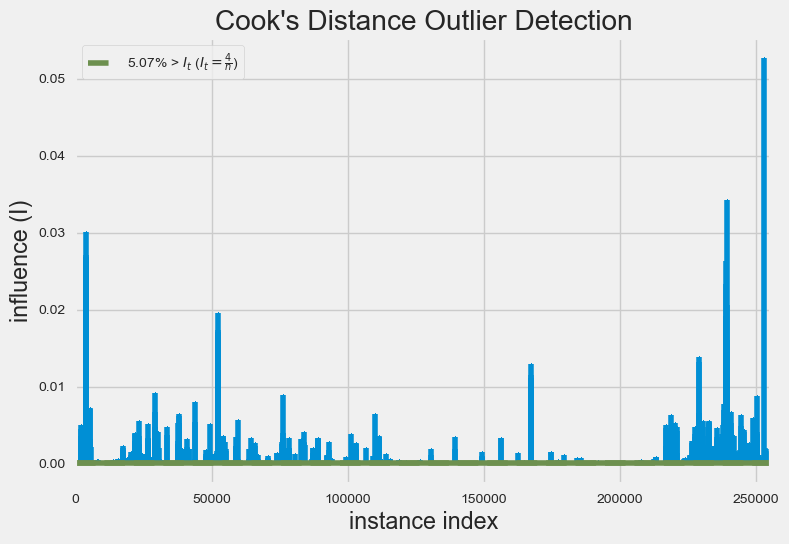

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [33]:
###################
### 2. Outliers ###
###################
imp_var = ['B01001_002E','B01001_026E','B07009_004E','B25013_002E','B07009_003E'] # top 5 features
X_cook = X_log[imp_var]

# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(X_cook, y)
visualizer.show()

In [34]:
### Influential Points
output = visualizer.fit(X_cook, y)
output.distance_.sort_values(ascending=False)

293369    0.052647
278779    0.034211
3907      0.030056
3912      0.027087
3908      0.026788
            ...   
253640    0.000000
41103     0.000000
284523    0.000000
268329    0.000000
28722     0.000000
Length: 255625, dtype: float64

In [35]:
inf_points = [293369, 278779, 3907, 3912, 3908]
d_price_fe2.loc[inf_points,:]

ZHVI  B01001A_001E  B01001A_017E  B01001_002E  B01001_026E  \
293369  5.950365e+05             0             0            0           77   
278779  1.605767e+06          2611          1514         1904         2295   
3907    3.697849e+06          1143           680          554          719   
3912    3.280670e+06           809           462          446          703   
3908    3.535509e+06          1221           713          594          765   

        B01002_001E  B01002_002E  B01002_003E  B01003_001E  B07009_002E  ...  \
293369         41.7         40.7        42.75           77          0.0  ...   
278779         31.8         30.6        34.00         4199         81.0  ...   
3907           46.8         35.9        61.10         1273          0.0  ...   
3912           42.0         39.9        44.30         1149         10.0  ...   
3908           52.5         41.9        59.20         1359         10.0  ...   

        B25013_002E  B25027_010E  B25031_001E  B25032_013E  B25036_002E  \
293369            0            0        890.0           77            0   
278779            0            0       3501.0         1340            0   
3907             29            9        756.0          792           29   
3912             22           22       3001.0          743           22   
3908             30           10        756.0          823           30   

        B25038_009E  B25042_009E  B25056_001E  B25087_001E  B25087_002E  
293369           77           77           77            0            0  
278779         1340         1340         1340            0            0  
3907            792          792          792           29           20  
3912            743          743          743           22            0  
3908            823          823          823           30           20  

[5 rows x 27 columns]